In [1]:
import numpy as np
from lora_modem import LoraModulator, LoraDemodulator

LoRa Synchronization

Fase 1: Agarramos la señal recibida e intentamos decodificar (desde el principio y a partir de 2^SF-SPC muestras) cualquier función base completa. Es decir, un upchirp o un downchirp. Si se halla una función base, se guarda el índice candidato y se para a la FASE 2. Si no, se sigue barriendo la señal recibida.

Fase 2: A partir de ese índice candidato, se intenta reconstruir varias funciones base, siguiendo de la otra (terminando en el downchirp de arribo ciclo 1). Si se logra, ese índice es un índice posible y se para a la FASE 3. Si no se logra reconstruir la trama, se vuelve a la FASE 1, pero omitiendo y eliminando al índice candidato que no era.

Fase 3: Se intenta reconstruir el preámbulo a partir del índice siguiente al índice posible de la Fase 2. Se recopilan las tramas de offsets contiguos, partir del índice posible de la fase anterior. Una vez se tengan las demás tramas se procede a determinar cuál es el offset que concuerda mejor (la potencia con respecto al resto). El resultado se toma como el índice correcto y finalmente la sincronización está completa. Se tiene el índice de inicio del payload. Se pasa a la Fase 4.

Fase 4: Ya no es tarea de sincronización, pero es importante: se demodula el símbolo que le procede al cuarto ciclo de downchirp que sí o sí representa la cantidad de símbolos transmitidos. De esta forma se sabe hasta qué muestra demodular el payload.

`payload_range= [payload_start_index: payload_start_index + spc * 2**sf * (n_simbolos + 1)]`

Demodulado `payload_start_index` en la Fase 4

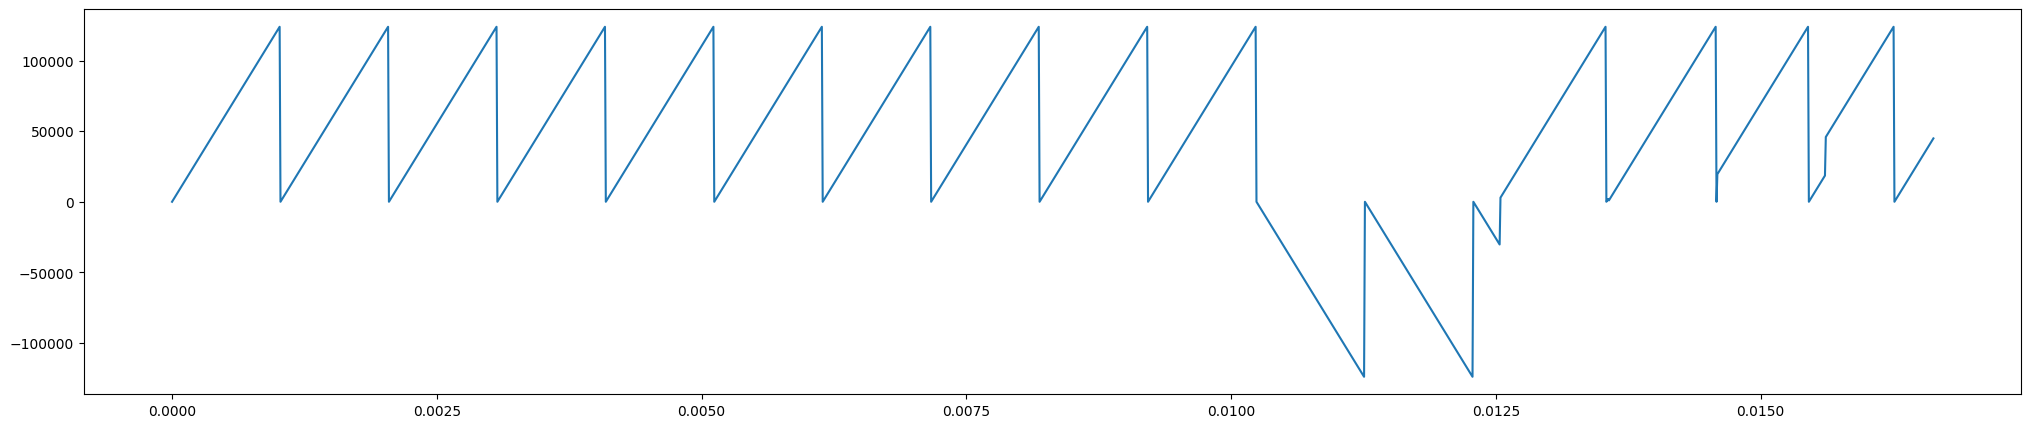

In [9]:
import matplotlib.pyplot as plt
spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 1
mod = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
demod = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)

# Generate the implicit package
payload = [1, 20, 47]

# Modulate the package
time, freq, tx_signal = mod.modulate_implicit_package(8, payload)

plt.figure(figsize=(25, 5))
plt.plot(time, freq)

# first, let's try to demodulate the signal:


In [3]:
    # def compute_synchronized_index(self, signal, preamble_number):
    #     '''
    #     This function computes the synchronized index of the LoRa modulation.

    #     Parameters:

    #     signal (np.array): The signal of the received LoRa modulation.
    #     preamble_number (int): The number of preambles in the package.

    #     Returns:

    #     synchronized_index (int): The synchronized index of the LoRa modulation.
    #     '''
        
    #     spc = self._samples_per_chip
    #     sf = self._spreading_factor
        
    #     correct_demodulated_preamble = [0 for i in range(preamble_number + 2)]
    #     for i in range(0, len(signal)):
    #         first_preamble_symbol_signal = signal[i:i + spc * 2**sf]
    #         symbol = self.demodulate_symbol(first_preamble_symbol_signal)
    #         if symbol == 0:
    #             print('An upchirp was encountered at ', i)
    #             preamble_symbol_signal = signal[i:(i + spc * 2**sf * (preamble_number + 2))] 
    #             demodulated_preamble = self.demodulate_symbols(preamble_symbol_signal)
    #             print('Demodulated preamble: ', demodulated_preamble)
    #             if demodulated_preamble == correct_demodulated_preamble:
    #                 payload_index = int(i + spc * 2**sf * (preamble_number + 4.25))
    #                 return payload_index
    #     return -1

    # def detect_preamble_member(self, signal, index):
    #     spc = self._samples_per_chip
    #     sf = self._spreading_factor
    #     symbol = self.demodulate_symbol(signal[index: index + spc * 2**sf], 'downchirp')
    #     if symbol == 0:
    #         return LoraReservedArtifacts.FULL_UPCHIRP, index, index + spc * 2**sf
    #     symbol = self.demodulate_symbol(signal[index: index + spc * 2**sf], 'upchirp')
    #     if symbol == 0:
    #         return LoraReservedArtifacts.FULL_DOWNCHIRP, index, index + spc * 2**sf
    #     symbol = self.demodulate_symbol(signal[index: index + (spc * 2**sf)//4], 'quarter_upchirp')
    #     if symbol == 0:
    #         return LoraReservedArtifacts.QUARTER_DOWNCHIRP, index, index + (spc * 2**sf)//4
    #     return None, index, index + 1
    
    # def possible_preamble_found(self, preamble):
    #     if len(preamble) == 0 or len(preamble) < 3:
    #         return False
    #     if preamble[-1] == LoraReservedArtifacts.QUARTER_DOWNCHIRP and preamble[-2] == LoraReservedArtifacts.FULL_DOWNCHIRP and preamble[-3] == LoraReservedArtifacts.FULL_DOWNCHIRP:
    #         return True
    #     return False

    # def detect_preambles(self, signal):
    #     spc = self._samples_per_chip
    #     sf = self._spreading_factor
    #     current_index = 0
    #     preamble = []
    #     # All the starting indices of the possible preambles for a given LoRa implicit package
    #     possible_preambles_starting_indices = []
        
    #     while current_index < len(signal):
    #         preamble_member, start_index, current_index = self.detect_preamble_member(signal, current_index)
    #         if preamble_member is None:
    #             continue
    #         preamble.append(preamble_member)
    #         if self.possible_preamble_found(preamble):
    #             possible_preambles_starting_indices.append(start_index)
    #             preamble = []
    #         current_index = current_index

In [10]:
from lora_modem import LoraModulator, LoraDemodulator, LoraReservedArtifacts
import numpy as np

class LoraSync:
    def __init__(self, spreading_factor, samples_per_chip, demodulator, preamble_number):
        self._spreading_factor = spreading_factor
        self._samples_per_chip = samples_per_chip
        self._demodulator = demodulator 
        self._preamble_number = preamble_number

    def _detect_chirp(self, signal_segment, chirp_type):
        """Helper function to detect specific chirp types in a given signal segment."""
        chirp_type = 'upchirp' if chirp_type == 'downchirp' else 'downchirp'
        return self._demodulator.demodulate_symbol(signal_segment, chirp_type) == 0

    def _get_samples_per_symbol(self):
        return self._samples_per_chip * 2 ** self._spreading_factor

    def phase1sync(self, rx_signal):
        sps = self._get_samples_per_symbol()
        
        for i in range(len(rx_signal)):
            # Extract the segment to analyze
            segment = rx_signal[i:i + sps]
            if len(segment) < sps:
                break
            # Check if the segment is an upchirp´
            if self._detect_chirp(segment, 'upchirp'):
                print('Upchirp detected at index: ', i)
                preamble_found, payload_index, reconstructed_preamble = self.phase2sync(rx_signal, i)
                if preamble_found:
                    print('Synchronization successful!')
                    package_length = self._demodulator.demodulate_symbol(rx_signal[payload_index:payload_index + sps], 'downchirp')
                    print('Package length: ', package_length)
                    if self._samples_per_chip>1:
                        print("(not) Refining synchronization... (SPC > 1 requires phase 3 synchronization, NOT IMPLEMENTED)")
                    return True, payload_index
        return False, -1
    
    def phase2sync(self, rx_signal, candidate_index):
        sps = self._get_samples_per_symbol()
        
        current_index = candidate_index + sps
        
        reconstructed_preamble = []
        while True:
            segment = rx_signal[current_index:current_index + sps]
            if len(segment) < sps:
                break
            if self._detect_chirp(segment, 'upchirp'):
                reconstructed_preamble.append(LoraReservedArtifacts.FULL_UPCHIRP)
                current_index += sps
                continue
            elif self._detect_chirp(segment, 'downchirp'):
                reconstructed_preamble.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                current_index += sps
                alleged_second_downchip = rx_signal[current_index:current_index + sps]
                if self._detect_chirp(alleged_second_downchip, 'downchirp'):
                    reconstructed_preamble.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    payload_index = int(current_index + sps * 1.25)
                    print('Payload index: ', payload_index)
                    upchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_UPCHIRP)
                    downchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_DOWNCHIRP)
                    print(f'Reconstructed preamble: [{upchirps + 1} upchirps, {downchirps} downchirps]')
                    return True, payload_index, reconstructed_preamble
                else:
                    break
            else:
                break
        return False, -1, -1
    

    
    def synchronize(self, rx_signal):
        self.phase1sync(rx_signal)

new_tx = np.roll(tx_signal, 10)
print(len(new_tx))
sync = LoraSync(spreading_factor, samples_per_chip, demod, preamble_number=5)
sync.phase1sync(new_tx)



2080
Upchirp detected at index:  10
Payload index:  1578
Reconstructed preamble: [10 upchirps, 2 downchirps]
Synchronization successful!
Package length:  3


(True, 1578)

In [5]:
# from lora_modem import LoraModulator, LoraDemodulator, LoraReservedArtifacts
# import numpy as np

# class LoraSync:
#     def __init__(self, spreading_factor, samples_per_chip, demodulator, preamble_number):
#         self._spreading_factor = spreading_factor
#         self._samples_per_chip = samples_per_chip
#         self._demodulator = demodulator 
#         self._preamble_number = preamble_number

#     def _detect_chirp(self, signal_segment, chirp_type):
#         """Helper function to detect specific chirp types in a given signal segment."""
#         return self._demodulator.demodulate_symbol(signal_segment, chirp_type) == 0

#     def _get_samples_per_symbol(self):
#         return self._samples_per_chip * 2 ** self._spreading_factor

#     def phase1sync(self, rx_signal):
#         sps = self._get_samples_per_symbol()
        
#         for i in range(len(rx_signal) - sps):
#             # Extract the segment to analyze
#             segment = rx_signal[i:i + sps]

#             if self._detect_chirp(segment, 'downchirp'):
#                 print(f'An upchirp was encountered at index {i}')
#                 found_preamble, payload_start_index = self.phase2sync(rx_signal, i)
                
#                 if found_preamble:
#                     package_size = self._demodulator.demodulate_symbol(
#                         rx_signal[payload_start_index:payload_start_index + sps], 'downchirp'
#                     )
#                     print(f'The preamble was found at index {i}')
#                     print(f'The package size is {package_size}')
#                     return i, package_size

#             elif self._detect_chirp(segment, 'upchirp'):
#                 print(f'A downchirp was encountered at index {i}')
#                 found_preamble, payload_start_index = self.phase2sync(rx_signal, i)

#                 if found_preamble:
#                     package_size = self._demodulator.demodulate_symbol(
#                         rx_signal[payload_start_index:payload_start_index + sps], 'downchirp'
#                     )
#                     print(f'The preamble was found at index {i}')
#                     print(f'The package size is {package_size}')
#                     return i, package_size

#         # If no preamble is found
#         print('No valid preamble detected.')
#         return -1, -1

#     def phase2sync(self, rx_signal, candidate_index):
#         """Phase 2 synchronization: Detect the full preamble sequence and identify payload start."""
#         print(f'Phase 2 synchronization: Starting from index {candidate_index}')
#         sps = self._get_samples_per_symbol()
#         reconstructed_preamble = []
#         current_index = candidate_index

#         while True:
#             segment = rx_signal[current_index : current_index + sps]

#             if self._detect_chirp(segment, 'downchirp'):
#                 print(f'phase2 upchirp {current_index}')
#                 reconstructed_preamble.append(LoraReservedArtifacts.FULL_UPCHIRP)
#             elif self._detect_chirp(segment, 'upchirp'):
#                 reconstructed_preamble.append(LoraReservedArtifacts.FULL_DOWNCHIRP)
#                 print(f'phase2 downchirp {current_index}')
#             elif self._detect_chirp(segment[: sps // 4], 'quarter_upchirp'):
#                 reconstructed_preamble.append(LoraReservedArtifacts.QUARTER_DOWNCHIRP)
#                 payload_start_index = current_index + sps // 4
#                 break
#             else:
#                 # If no valid chirp is detected, abort the preamble detection
#                 print('Invalid chirp detected. Aborting preamble detection.')
#                 return False, -1

#             current_index += sps

#         # Check if the preamble format matches the expected pattern
#         if reconstructed_preamble and reconstructed_preamble[-1] == LoraReservedArtifacts.QUARTER_DOWNCHIRP:
#             upchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_UPCHIRP)
#             downchirps = reconstructed_preamble.count(LoraReservedArtifacts.FULL_DOWNCHIRP)

#             print(f'Found preamble: [{upchirps} Upchirps, {downchirps} Downchirps, Quarter Downchirp]')
#             return True, payload_start_index

#         return False, -1

# # Example Usage
# new_tx = tx_signal
# sync = LoraSync(spreading_factor, samples_per_chip, demod, preamble_number=5)
# sync.phase1sync(new_tx)


In [ ]:
# SDR 